In [1]:
from pyspark.sql import *
import pyspark.sql.functions as F
import pyspark.sql.types as T
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

%matplotlib inline

# BEFORE START
# PLASE DOWNLOAD DATASET FROM THIS GOOGLE DRIVE
https://drive.google.com/open?id=1DBZ1XgI9Dp9hzTVNYyHvS8Ze3O4PiRKK
## At section 6 and 7, save as and read from parquet at the beginning of section before proceeding is recommended. Otherwise will take very long to run

# 1. Get Data
- The dataset is from GHarchive:year.2017 and GHarchive:year.2018
- This is different from GHTorrent used in V2
- Reason of switching from GHTorrent to GHarchive is GHarchive have more information regarding pull requests
- This section all codes are done one Google BigQuery
- Final selected data is saved as JSON file and be used in next section


### ALL CODES IN THIS SECTION CANNOT BE RUN ON NOTEBOOK, THEY ARE FOR BIGQUERY

### 1.1 Step 1 select most popular repository
- repository popularity are based on how many WatchEvent happened to a repository from 2017 to 2018
- WatchEvent can only be started as stated in https://developer.github.com/v3/activity/events/types/
- Select top 3000 popular repositories. Limit 3000 to limit size of data 
- Syntax is Legacy SQL
- The result of this step is saved on BigQuery

### 1.2 Step 2 Query all PullRequestEvents happened from 2017 to 2018 in the 1000 repository
- This step returns 2,384,122 rows of pull request events
- Use table ys-2-236822:GH2.step1_popular_repository saved on BigQuery from step 1
- Syntax is Legacy SQL
- The result is saved on BigQuery

### 1.3 Step 3 filter by only having pull requests from repository with >= 200 pull requests opened and >= 10 merged 
- This step returns 2,291,579 rows of pull request events
- Use table ys-2-236822:GH2.step2_repositrys_pull_requests saved from step 2
- Syntax is Legacy SQL
- The result is saved on BigQuery

### 1.4 Step 4 select initial data
- This step returns 2,291,579 rows of pull requests with certain columns selected
- Use table ys-2-236822.GH2.step3_filter_repository saved from step 3
- Syntax is Standard SQL
- The result is saved on BigQuery

### 1.5 Step 5 Select data for downloading
- This step returns 1,130,186 rows of pull requests
- Syntax is standard SQL
- Use table ys-2-236822.GH2.step4 saved from step 4
- The result is saved on BigQuery
- The motive of choosing closed pull requests is explained in next section
- The result is downloaded as gha_pre.json file

# 2. Read Data
- I choose pull requests that are closed. Their acceptance status are indicated by 'merged' column. The reason I choose pull request with "closed" actions instead of "opened" actions because "closed" pull requests reflects the full property of the pull request.
- For example, when a pull request just opened, there won't be reviews showing up in the pull request event payload.

In [2]:
pull_request_JSON = spark.read.json('gha_pre.json')

In [3]:
pull_request_JSON.printSchema()

root
 |-- action: string (nullable = true)
 |-- additions: string (nullable = true)
 |-- author_id: string (nullable = true)
 |-- body: string (nullable = true)
 |-- closed_time: string (nullable = true)
 |-- comments: string (nullable = true)
 |-- commits: string (nullable = true)
 |-- created_time: string (nullable = true)
 |-- deletions: string (nullable = true)
 |-- files_change: string (nullable = true)
 |-- merged: string (nullable = true)
 |-- merged_time: string (nullable = true)
 |-- pr_id: string (nullable = true)
 |-- review_comments: string (nullable = true)
 |-- rp_id: string (nullable = true)
 |-- title: string (nullable = true)



In [4]:
pull_request_JSON.first()

Row(action='closed', additions='377', author_id='11607785', body='76', closed_time='2018-08-20T15:08:28Z', comments='0', commits='3', created_time='2018-08-20T15:06:45Z', deletions='28', files_change='5', merged='false', merged_time=None, pr_id='209552173', review_comments='0', rp_id='104208128', title='update jni with lock and exception logics && add java interface close #807')

In [5]:
pull_request_JSON.createOrReplaceTempView('raw_DF')

### 2.1 Cast data into right type

In [6]:
spark.sql("""
SELECT
action,
CAST(additions as BIGINT) as additions,
CAST(author_id as BIGINT) as author_id,
CAST(body as BIGINT) as body,
CAST(comments as INT) as comments,
CAST(commits as INT) as commits,
CAST(created_time as TIMESTAMP) as created_time,
CAST(closed_time as TIMESTAMP) as closed_time,
CAST(deletions as BIGINT) as deletions,
CAST(files_change as BIGINT) as files_change,
merged,
CAST(merged_time as TIMESTAMP) as merged_time,
CAST(pr_id as BIGINT) as pr_id,
CAST(review_comments as INT) as review_comments,
title,
CAST(rp_id as BIGINT) as rp_id
FROM raw_DF
""").printSchema()

root
 |-- action: string (nullable = true)
 |-- additions: long (nullable = true)
 |-- author_id: long (nullable = true)
 |-- body: long (nullable = true)
 |-- comments: integer (nullable = true)
 |-- commits: integer (nullable = true)
 |-- created_time: timestamp (nullable = true)
 |-- closed_time: timestamp (nullable = true)
 |-- deletions: long (nullable = true)
 |-- files_change: long (nullable = true)
 |-- merged: string (nullable = true)
 |-- merged_time: timestamp (nullable = true)
 |-- pr_id: long (nullable = true)
 |-- review_comments: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- rp_id: long (nullable = true)



In [7]:
spark.sql("""
SELECT
action,
CAST(additions as BIGINT) as additions,
CAST(author_id as BIGINT) as author_id,
CAST(body as BIGINT) as body,
CAST(comments as INT) as comments,
CAST(commits as INT) as commits,
CAST(created_time as TIMESTAMP) as created_time,
CAST(closed_time as TIMESTAMP) as closed_time,
CAST(deletions as BIGINT) as deletions,
CAST(files_change as BIGINT) as files_change,
merged,
CAST(merged_time as TIMESTAMP) as merged_time,
CAST(pr_id as BIGINT) as pr_id,
CAST(review_comments as INT) as review_comments,
title,
CAST(rp_id as BIGINT) as rp_id
FROM raw_DF
""").createOrReplaceTempView('pr_DF')

# 3. Clean

### 3.1 Check quality of the data, look for null values

In [8]:
pull_request_DF = spark.sql("""
SELECT * FROM pr_DF
""")

In [9]:
pull_request_DF.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in pull_request_DF.columns]).show()

+------+---------+---------+----+--------+-------+------------+-----------+---------+------------+------+-----------+-----+---------------+-----+-----+
|action|additions|author_id|body|comments|commits|created_time|closed_time|deletions|files_change|merged|merged_time|pr_id|review_comments|title|rp_id|
+------+---------+---------+----+--------+-------+------------+-----------+---------+------------+------+-----------+-----+---------------+-----+-----+
|     0|        0|        0|8063|       0|      0|           0|         83|        0|           0|     0|     292826|    0|              0|    0|    0|
+------+---------+---------+----+--------+-------+------------+-----------+---------+------------+------+-----------+-----+---------------+-----+-----+



- 'body' column is null means that the pull request body has no message, convert to 0 in this case
- 'merged_time" is null means the pull request did not merged, so it doesn't have values. This does not interfere with model prediction because in latency prediction, i only look at pull requests that are merged in the end
- closed_time is null cannot be explained. It should be included if the pull request is closed. I assume that is abnormality. Remove the rows with it. It only has 83 such rows.

### 3.2 Remove the rows with null closed_time, make null values in body column to 0

In [10]:
pull_request_DF = spark.sql("""
SELECT * FROM pr_DF
WHERE closed_time IS NOT NULL
""")

In [11]:
pull_request_DF = spark.sql("""
SELECT
action,
additions,
author_id,
CASE WHEN body IS NULL THEN 0 ELSE body END AS body,
comments,
commits,
created_time,
closed_time,
deletions,
files_change,
merged,
merged_time,
pr_id,
review_comments,
title,
rp_id
FROM pr_DF
WHERE closed_time IS NOT NULL
""")

In [12]:
pull_request_DF.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in pull_request_DF.columns]).show()

+------+---------+---------+----+--------+-------+------------+-----------+---------+------------+------+-----------+-----+---------------+-----+-----+
|action|additions|author_id|body|comments|commits|created_time|closed_time|deletions|files_change|merged|merged_time|pr_id|review_comments|title|rp_id|
+------+---------+---------+----+--------+-------+------------+-----------+---------+------------+------+-----------+-----+---------------+-----+-----+
|     0|        0|        0|   0|       0|      0|           0|          0|        0|           0|     0|     292744|    0|              0|    0|    0|
+------+---------+---------+----+--------+-------+------------+-----------+---------+------------+------+-----------+-----+---------------+-----+-----+



### Dataset description after removing null closed_time

In [13]:
pull_request_DF.describe(pull_request_DF.columns).toPandas()

,summary,action,additions,author_id,body,comments,commits,deletions,files_change,merged,pr_id,review_comments,title,rp_id
0,count,1130103,1130103,1130103,1130103,1130103,1130103,1130103,1130103,1130103,1130103,1130103,1130103,1130103
1,mean,None,1393.490688016933,7502370.563319449,494.613302504285,2.6977602926458917,8.236798769669667,741.8403331377759,18.129995230523235,None,1.63292513469428E8,1.932849483631138,1.9695025641215992E13,3.462955597017794E7
2,stddev,None,52404.220740722965,9346027.090780158,1471.4566100986647,5.613624079679758,147.28142153636958,31497.614544087275,368.15066009129515,None,4.328926639526936E7,8.035176403538584,4.888171699202349E14,3.0313188409802787E7
3,min,closed,0,1,0,0,0,0,0,false,34433,0,Chore: rewrite parseListConfig for a small pe...,3282
4,max,closed,18326933,46401660,232314,565,10000,10429480,125653,true,242466879,821,🦆 extract the cdn,156648725


In [14]:
pull_request_DF.createOrReplaceTempView('pr_DF')

# 4. Exploration and Selection

### 4.1 Number of pull requests every Quarter in 2017, 2018

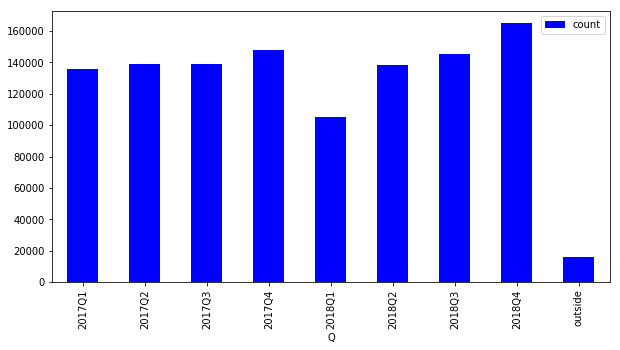

In [15]:
spark.sql("""
SELECT (CASE 
    WHEN closed_time BETWEEN '2017-01-01' AND '2017-03-31' THEN "2017Q1"
    WHEN closed_time BETWEEN '2017-04-01' AND '2017-06-30' THEN "2017Q2"
    WHEN closed_time BETWEEN '2017-07-01' AND '2017-09-30' THEN "2017Q3"
    WHEN closed_time BETWEEN '2017-10-01' AND '2017-12-31' THEN "2017Q4"
    WHEN closed_time BETWEEN '2018-01-01' AND '2018-03-31' THEN "2018Q1"
    WHEN closed_time BETWEEN '2018-04-01' AND '2018-06-30' THEN "2018Q2"
    WHEN closed_time BETWEEN '2018-07-01' AND '2018-09-30' THEN "2018Q3"
    WHEN closed_time BETWEEN '2018-10-01' AND '2018-12-31' THEN "2018Q4"
    ELSE "outside"
    END
    ) as Q, COUNT(1) as count FROM pr_DF
GROUP BY Q
ORDER BY Q
""").toPandas().plot(kind="bar", x="Q", y="count", figsize=(10,5), color="blue")

In [16]:
spark.sql("""
SELECT MAX(closed_time)
FROM pr_DF
""").show()

+-------------------+
|   max(closed_time)|
+-------------------+
|2019-01-05 23:59:09|
+-------------------+



In [17]:
spark.sql("""
SELECT MIN(closed_time)
FROM pr_DF
""").show()

+-------------------+
|   min(closed_time)|
+-------------------+
|2017-01-01 00:06:00|
+-------------------+



#### Comment:
- somehow pull requests closed outside 2017/2018 year got into the dataset. Even Though the original dataset on BigQuery was from gharchive:year.2017 and gharchive:.year.2018. This does not heavily affect the data, as see the latest date is 2019-01-5. In this case I will treat it as in 2018Q4

### 4.2 Accepted pull request latency distribution
- How long does it take pull request to get accpted?

In [18]:
def duration(start, end):

    elapsed = end - start
    if elapsed <= datetime.timedelta(minutes = 1):
        return "instantly"
    if datetime.timedelta(minutes = 1) < elapsed <= datetime.timedelta(hours = 1):
        return "within_hour"
    elif datetime.timedelta(hours = 1) < elapsed <= datetime.timedelta(days = 1):
        return "within_day"
    elif datetime.timedelta(days = 1) < elapsed <= datetime.timedelta(days = 7):
        return "within_week"
    elif datetime.timedelta(days = 7) < elapsed <= datetime.timedelta(days = 30):
        return "within_month"
    elif datetime.timedelta(days = 30) < elapsed <= datetime.timedelta(days = 90):
        return "within_quarter"
    elif datetime.timedelta(days = 90) < elapsed <= datetime.timedelta(days = 180):
        return "within_half_year"
    elif datetime.timedelta(days = 180) < elapsed <= datetime.timedelta(days = 365):
        return "within_year"
    else:    
        return "took_ages"
    
spark.udf.register("time_diff", duration, T.StringType())

<function __main__.duration(start, end)>

In [19]:
latency = spark.sql("""
SELECT year, time_diff(created_time, merged_time) as latency, COUNT(1) as count
FROM(
    SELECT (CASE
        WHEN closed_time < "2018-01-01" THEN "2017"
        ELSE "2018"
        END
    
    ) as year, created_time, merged_time
    FROM pr_DF
    WHERE merged = "true"
)
GROUP BY year, latency
""").toPandas()

In [20]:
spark.sql("""
SELECT year, time_diff(created_time, merged_time) as latency, COUNT(1) as count
FROM(
    SELECT (CASE
        WHEN closed_time < "2018-01-01" THEN "2017"
        ELSE "2018"
        END
    
    ) as year, created_time, merged_time
    FROM pr_DF
    WHERE merged = "true"
)
GROUP BY year, latency
ORDER BY year
""").show()

+----+----------------+------+
|year|         latency| count|
+----+----------------+------+
|2017|  within_quarter| 14265|
|2017|     within_week|105241|
|2017|     within_year|  1580|
|2017|      within_day|162723|
|2017|    within_month| 45947|
|2017|       took_ages|   526|
|2017|       instantly| 11061|
|2017|     within_hour| 73024|
|2017|within_half_year|  3758|
|2018|    within_month| 48824|
|2018|     within_hour| 64376|
|2018|     within_year|  1968|
|2018|       took_ages|   703|
|2018|  within_quarter| 15961|
|2018|       instantly| 15448|
|2018|     within_week|107765|
|2018|within_half_year|  4198|
|2018|      within_day|159991|
+----+----------------+------+



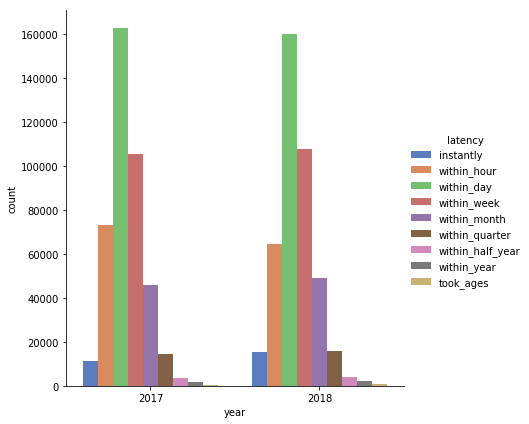

In [21]:
g = sns.catplot(x="year", y="count", hue="latency", data=latency, 
                hue_order = ["instantly", "within_hour","within_day", "within_week","within_month","within_quarter","within_half_year", "within_year", "took_ages"],
                height=6, kind="bar", palette="muted")

### Comment:
- Most pull requests accepted within day and week

### 4.3 Repository acceptance distribution
- Bin repositories by acceptance rate every 10%

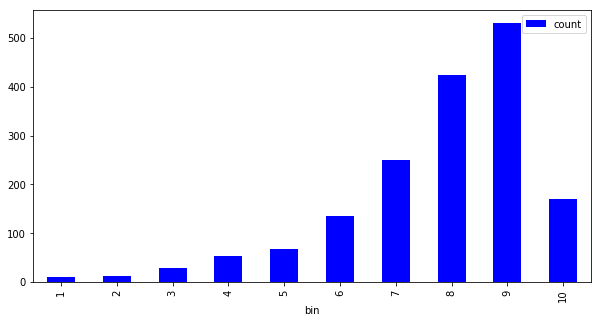

In [22]:
spark.sql("""
SELECT bin, COUNT(1) as count
FROM(
    SELECT CEIL(percentage * 10) AS bin
    FROM(
        SELECT DISTINCT rp_id, COUNT(CASE WHEN merged = "true" THEN 1 END) over (PARTITION BY rp_id)/COUNT(1) over (PARTITION BY rp_id) as percentage
        FROM pr_DF
    )
) 
GROUP BY bin
ORDER BY bin
""").toPandas().plot(kind="bar", x="bin", y="count", figsize=(10,5), color="blue")

### Commnet:
- There is a tail forming on the acceptance distribution
- I will consider removing the tail with bins below 4 from the dataset


### 4.4 Remove repositories below bin 4

In [23]:
spark.sql("""
SELECT * FROM pr_DF
WHERE rp_id IN
    (SELECT rp_id
    FROM(
        SELECT rp_id, CEIL(percentage * 10) AS bin
        FROM(
            SELECT DISTINCT rp_id, COUNT(CASE WHEN merged = "true" THEN 1 END) over (PARTITION BY rp_id)/COUNT(1) over (PARTITION BY rp_id) as percentage
            FROM pr_DF
        )
    )
    WHERE bin >= 4
    )
""").describe().toPandas()

,summary,action,additions,author_id,body,comments,commits,deletions,files_change,merged,pr_id,review_comments,title,rp_id
0,count,1055261,1055261,1055261,1055261,1055261,1055261,1055261,1055261,1055261,1055261,1055261,1055261,1055261
1,mean,None,1388.1788865503415,7600165.654518645,492.2935074829829,2.6477733944493353,7.850660642248695,735.5735462601195,17.805834765048647,None,1.638554163457827E8,1.9060156681617155,2.1434868895738727E13,3.4868027980974376E7
2,stddev,None,52848.55970535548,9460964.908711387,1472.8017163110187,5.536170999702019,142.33315344992042,31689.36380743662,365.92795966336746,None,4.322899256442379E7,7.926398726552914,5.099511702024052E14,3.0890428629999075E7
3,min,closed,0,1,0,0,0,0,0,false,34433,0,Chore: rewrite parseListConfig for a small pe...,3282
4,max,closed,18326933,46401660,232314,565,10000,10429480,125653,true,242466879,821,🦆 extract the cdn,156648725


In [24]:
spark.sql("""
SELECT * FROM pr_DF
WHERE rp_id IN
    (SELECT rp_id
    FROM(
        SELECT rp_id, CEIL(percentage * 10) AS bin
        FROM(
            SELECT DISTINCT rp_id, COUNT(CASE WHEN merged = "true" THEN 1 END) over (PARTITION BY rp_id)/COUNT(1) over (PARTITION BY rp_id) as percentage
            FROM pr_DF
        )
    )
    WHERE bin >= 4
    )
""").createOrReplaceTempView('pr_DF')

### 4.5 Remove repository which don't have 90% pull requests merged within hour, day, week and month.


In [25]:
spark.sql("""
SELECT
rp_id 
FROM(
    SELECT rp_id, 
    within_hour_count/total as hour_ratio,
    within_day_count/total as day_ratio,
    within_week_count/total as week_ratio,
    within_month_count/total as month_ratio
    FROM(
        SELECT
        rp_id,
        SUM(CASE WHEN latency = "within_hour" THEN 1 ELSE 0 END) as within_hour_count,
        SUM(CASE WHEN latency = "within_day" THEN 1 ELSE 0 END) as within_day_count,
        SUM(CASE WHEN latency = "within_week" THEN 1 ELSE 0 END) as within_week_count,
        SUM(CASE WHEN latency = "within_month" THEN 1 ELSE 0 END) as within_month_count,
        COUNT(1) as total
        FROM(
            SELECT rp_id, time_diff(created_time, merged_time) as latency
            FROM pr_DF
            WHERE merged = "true"
        )
        GROUP BY rp_id
    )
)
WHERE (hour_ratio + day_ratio + week_ratio + month_ratio) >= 0.9 
""").createOrReplaceTempView('repo_latency_group')

In [26]:
spark.sql("""
SELECT *
FROM pr_DF 
WHERE rp_id IN (SELECT * FROM repo_latency_group)

""").createOrReplaceTempView('pr_DF')

### 4.6 Latency distirbution after selection

In [27]:
latency = spark.sql("""
SELECT year, time_diff(created_time, merged_time) as latency, COUNT(1) as count
FROM(
    SELECT (CASE
        WHEN closed_time < "2018-01-01" THEN "2017"
        ELSE "2018"
        END
    
    ) as year, created_time, merged_time
    FROM pr_DF
    WHERE merged = "true"
)
GROUP BY year, latency
ORDER BY year
""").toPandas()

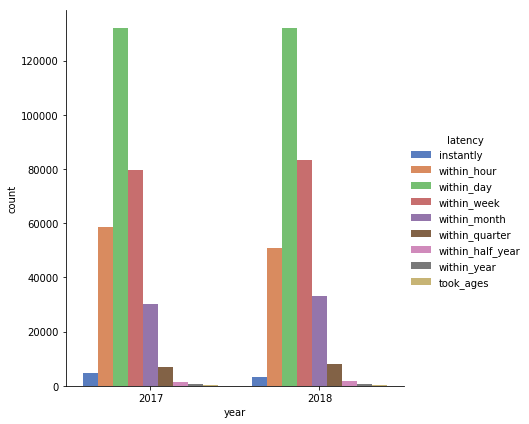

In [28]:
g = sns.catplot(x="year", y="count", hue="latency", data=latency, 
                hue_order = ["instantly", "within_hour","within_day", "within_week","within_month","within_quarter","within_half_year", "within_year", "took_ages"],
                height=6, kind="bar", palette="muted")

In [29]:
latency = spark.sql("""
SELECT time_diff(created_time, merged_time) as latency, COUNT(1) as count
FROM pr_DF
WHERE merged = "true"
GROUP BY latency

""").show()

+----------------+------+
|         latency| count|
+----------------+------+
|      within_day|263989|
|  within_quarter| 15074|
|       took_ages|   297|
|     within_week|162923|
|       instantly|  8062|
|     within_hour|109204|
|    within_month| 63281|
|within_half_year|  3316|
|     within_year|  1258|
+----------------+------+



### 4.7 Acceptance Rate after Selection

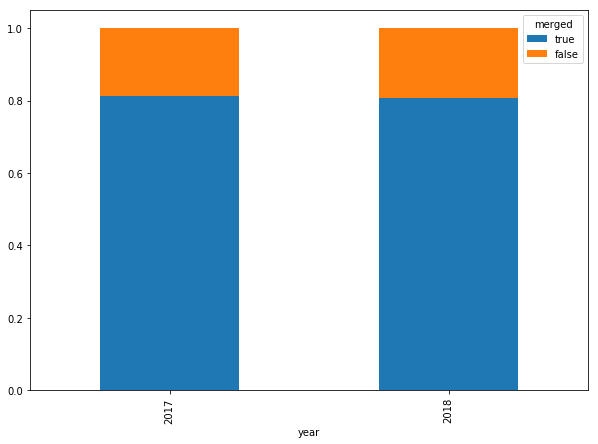

In [30]:
spark.sql("""
SELECT DISTINCT year, merged, COUNT(1) over (PARTITION BY year, merged)/COUNT(1) over (PARTITION BY year) as percentage
FROM(
    SELECT (CASE
        WHEN closed_time < "2018-01-01" THEN "2017"
        ELSE "2018"
        END 
    
    ) as year, merged
    FROM pr_DF
)
""").toPandas().pivot(index='year', columns='merged', values='percentage').loc[:,['true','false']].plot.bar(stacked=True, figsize=(10,7))

In [31]:
spark.sql("""
SELECT * FROM pr_DF
""").describe().toPandas()

,summary,action,additions,author_id,body,comments,commits,deletions,files_change,merged,pr_id,review_comments,title,rp_id
0,count,774502,774502,774502,774502,774502,774502,774502,774502,774502,774502,774502,774502,774502
1,mean,None,1234.6454625036474,7138707.250058748,478.7172815564066,2.58610048779732,6.85801327820974,689.3032077386501,16.191821325187025,None,1.6455315540014875E8,2.0027863065556963,3.5456219524355404E7,3.769980948876569E7
2,stddev,None,47504.896367436384,9022770.516413689,1398.2595055259171,5.468995182016576,113.97773923266878,29900.122482971183,325.28457582395515,None,4.226029005769833E7,8.023499025859282,6.608456063902555E8,3.1322573533145275E7
3,min,closed,0,4,0,0,0,0,0,false,1213020,0,Chore: rewrite parseListConfig for a small pe...,8514
4,max,closed,14000792,46401660,232314,565,10000,7813435,125653,true,242466879,821,🦄 Added /edit/ redirect to admin for post prev...,156648725


# 5. Features and labels

### 5.1 UDF Search for title for "fix" or "bug" identify pull request as bug fix

In [32]:
import re
regexp =re.compile(r"(?:^|\W)fix(?:$|\W)",re.I)
regexp2 = re.compile(r"(?:^|\W)bug(?:$|\W)",re.I)
def bug_fix(string):
    return bool(re.search(regexp, string)) or bool(re.search(regexp2, string))

spark.udf.register("bug_fix", bug_fix, T.BooleanType())

<function __main__.bug_fix(string)>

### 5.2 UDF Convert merged status string to boolean ("true"/"false") to (True/False)

In [33]:
def merged_status(string):
    return string == "true"
spark.udf.register("merged_status", merged_status, T.BooleanType())

<function __main__.merged_status(string)>

### 5.3 Extract features and label from dataframe
- Some of the features proposed in the paper are not directly available in dataset

In [34]:
spark.sql("""
SELECT

COUNT(1) over (PARTITION BY author_id ORDER BY closed_time ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING) AS pr_exp, 
COUNT(CASE WHEN merged = "true" THEN 1 END) over (PARTITION BY author_id ORDER BY closed_time ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING) AS commit_exp,
body,
YEAR(created_time) as create_year,
MONTH(created_time) as create_month,
WEEKOFYEAR(created_time) as create_week,
DAYOFYEAR(created_time) as create_day,
(comments + review_comments) as reviews,
commits,
files_change,
bug_fix(title) as fix,
COUNT(CASE WHEN merged = "true" THEN 1 END) over (PARTITION BY rp_id ORDER BY closed_time ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING) as repo_popularity, 
closed_time,
merged_status(merged) as merged

FROM pr_DF
""").printSchema()

root
 |-- pr_exp: long (nullable = false)
 |-- commit_exp: long (nullable = false)
 |-- body: long (nullable = true)
 |-- create_year: integer (nullable = true)
 |-- create_month: integer (nullable = true)
 |-- create_week: integer (nullable = true)
 |-- create_day: integer (nullable = true)
 |-- reviews: integer (nullable = true)
 |-- commits: integer (nullable = true)
 |-- files_change: long (nullable = true)
 |-- fix: boolean (nullable = true)
 |-- repo_popularity: long (nullable = false)
 |-- closed_time: timestamp (nullable = true)
 |-- merged: boolean (nullable = true)



In [36]:
accept_DF = spark.sql("""
SELECT

COUNT(1) over (PARTITION BY author_id ORDER BY closed_time ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING) AS pr_exp, 
COUNT(CASE WHEN merged = "true" THEN 1 END) over (PARTITION BY author_id ORDER BY closed_time ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING) AS commit_exp,
body,
YEAR(created_time) as create_year,
MONTH(created_time) as create_month,
WEEKOFYEAR(created_time) as create_week,
DAYOFYEAR(created_time) as create_day,
(comments + review_comments) as reviews,
commits,
files_change,
bug_fix(title) as fix,
COUNT(CASE WHEN merged = "true" THEN 1 END) over (PARTITION BY rp_id ORDER BY closed_time ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING) as repo_popularity, 
closed_time,
merged_status(merged) as merged

FROM pr_DF
""")

## 6. Pull Request Acceptance Prediction

In [37]:
# accept_DF.write.mode('overwrite').parquet('accept_parquet3')

In [21]:
# accept_DF = spark.read.parquet('accept_parquet3')

### 6.1 Prepare dataset for ML pipeline

In [22]:
accept_DF = accept_DF.withColumn('bug', accept_DF.fix.cast('integer'))

In [23]:
categoricalColumns = []
numericCols = ['pr_exp', 'commit_exp', 'body','bug','create_year','create_month','create_week','create_day','reviews','commits','files_change','repo_popularity']

stages = []

assemblerInputs = numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [24]:
accept_DF = accept_DF.withColumn('label', accept_DF.merged.cast('integer'))

In [25]:
accept_DF.printSchema()

root
 |-- pr_exp: long (nullable = true)
 |-- commit_exp: long (nullable = true)
 |-- body: long (nullable = true)
 |-- create_year: integer (nullable = true)
 |-- create_month: integer (nullable = true)
 |-- create_week: integer (nullable = true)
 |-- create_day: integer (nullable = true)
 |-- reviews: integer (nullable = true)
 |-- commits: integer (nullable = true)
 |-- files_change: long (nullable = true)
 |-- fix: boolean (nullable = true)
 |-- repo_popularity: long (nullable = true)
 |-- closed_time: timestamp (nullable = true)
 |-- merged: boolean (nullable = true)
 |-- bug: integer (nullable = true)
 |-- label: integer (nullable = true)



In [26]:
stages

[VectorAssembler_4263ab2821f8d5c0b6b9]

In [27]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(accept_DF)
accept_DF_transformed = pipelineModel.transform(accept_DF)

selectedCols = ['label','features'] +['closed_time']
accept_DF_transformed = accept_DF_transformed.select(selectedCols)
accept_DF_transformed.printSchema()
accept_DF_transformed.createOrReplaceTempView('acceptance_DF')

root
 |-- label: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- closed_time: timestamp (nullable = true)



### 6.2 Split the dataset every 3 months

In [28]:
accept_DF_transformed_Q1 = spark.sql("""
SELECT features, label FROM acceptance_DF
WHERE closed_time BETWEEN '2017-01-01' AND '2017-03-31'
""")

In [29]:
accept_DF_transformed_Q2 = spark.sql("""
SELECT features, label FROM acceptance_DF
WHERE closed_time BETWEEN '2017-04-01' AND '2017-06-30'
""")

In [30]:
accept_DF_transformed_Q3 = spark.sql("""
SELECT features, label FROM acceptance_DF
WHERE closed_time BETWEEN '2017-07-01' AND '2017-09-30'
""")

In [31]:
accept_DF_transformed_Q4 = spark.sql("""
SELECT features, label FROM acceptance_DF
WHERE closed_time BETWEEN '2017-10-01' AND '2017-12-31'
""")

In [32]:
accept_DF_transformed_Q5 = spark.sql("""
SELECT features, label FROM acceptance_DF
WHERE closed_time BETWEEN '2018-01-01' AND '2018-03-31'
""")

In [33]:
accept_DF_transformed_Q6 = spark.sql("""
SELECT features, label FROM acceptance_DF
WHERE closed_time BETWEEN '2018-04-01' AND '2018-06-30'
""")

In [34]:
accept_DF_transformed_Q7 = spark.sql("""
SELECT features, label FROM acceptance_DF
WHERE closed_time BETWEEN '2018-07-01' AND '2018-09-30'
""")

In [35]:
accept_DF_transformed_Q8 = spark.sql("""
SELECT features, label FROM acceptance_DF
WHERE closed_time > '2018-10-01'
""")

### 6.3 Split Each Quarter data into training and testing set

In [36]:
train1, test1 = accept_DF_transformed_Q1.randomSplit([0.7, 0.3], seed = 1000)
train2, test2 = accept_DF_transformed_Q2.randomSplit([0.7, 0.3], seed = 1000)
train3, test3 = accept_DF_transformed_Q3.randomSplit([0.7, 0.3], seed = 1000)
train4, test4 = accept_DF_transformed_Q4.randomSplit([0.7, 0.3], seed = 1000)
train5, test5 = accept_DF_transformed_Q5.randomSplit([0.7, 0.3], seed = 1000)
train6, test6 = accept_DF_transformed_Q6.randomSplit([0.7, 0.3], seed = 1000)
train7, test7 = accept_DF_transformed_Q7.randomSplit([0.7, 0.3], seed = 1000)
train8, test8 = accept_DF_transformed_Q8.randomSplit([0.7, 0.3], seed = 1000)

### 6.4 Basic model numTrees = 100

In [37]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', numTrees = 100, seed = 1000)    

In [38]:
rf_model1 = rf.fit(train1)
rf_model2 = rf.fit(train2)
rf_model3 = rf.fit(train3)
rf_model4 = rf.fit(train4)
rf_model5 = rf.fit(train5)
rf_model6 = rf.fit(train6)
rf_model7 = rf.fit(train7)
rf_model8 = rf.fit(train8)

#### 6.4.1 Evaluate model with areaUnderPR

In [39]:
evaluator = BinaryClassificationEvaluator().setMetricName("areaUnderPR")

evaluator_scores = [evaluator.evaluate(rf_model1.transform(test1)),
                   evaluator.evaluate(rf_model2.transform(test2)),
                   evaluator.evaluate(rf_model3.transform(test3)),
                   evaluator.evaluate(rf_model4.transform(test4)),
                   evaluator.evaluate(rf_model5.transform(test5)),
                   evaluator.evaluate(rf_model6.transform(test6)),
                   evaluator.evaluate(rf_model7.transform(test7)),
                   evaluator.evaluate(rf_model8.transform(test8))]

spark.createDataFrame(evaluator_scores, T.FloatType()).describe().show()

+-------+--------------------+
|summary|               value|
+-------+--------------------+
|  count|                   8|
|   mean|  0.9190235510468483|
| stddev|0.006288606824150432|
|    min|           0.9103952|
|    max|           0.9284395|
+-------+--------------------+



#### 6.4.2 Feature Importance heatmap
- Darker color higher importance

In [40]:

data_frame_columns = ['pr_exp', 'commit_exp', 'body','bug','create_year','create_month','create_week','create_day','reviews','commits','files_change','repo_popularity']

important_feature_array = [rf_model1.featureImportances.toArray(),
                          rf_model2.featureImportances.toArray(),
                          rf_model3.featureImportances.toArray(),
                          rf_model4.featureImportances.toArray(),
                          rf_model5.featureImportances.toArray(),
                          rf_model6.featureImportances.toArray(),
                          rf_model7.featureImportances.toArray(),
                          rf_model8.featureImportances.toArray()]
quarters = ['2017Q1', 
            '2017Q2',
            '2017Q3',
            '2017Q4',
            '2018Q1',
            '2018Q2',
            '2018Q3',
            '2018Q4']
fi_df = pd.DataFrame(important_feature_array, index = quarters, columns =  data_frame_columns ).T

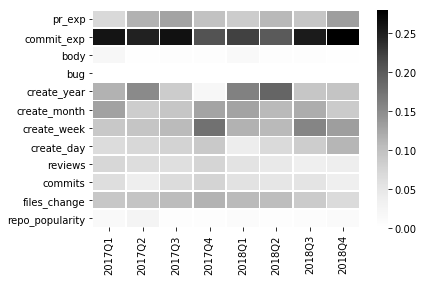

In [41]:
g = sns.heatmap(fi_df, linewidth = 0.5, cmap = 'Greys')

#### 6.4.3 Feature Importance Average Rank
- Smaller number means higher importance

In [42]:
rf_output = [[important_feature_array[i].tolist()[j], 
              quarters[i],
              data_frame_columns[j]] 
             for i in range(len(quarters)) for j in range(len(data_frame_columns))]

cSchema = T.StructType([T.StructField("feature_importance", T.DoubleType())\
                      ,T.StructField("quarter", T.StringType())\
                      ,T.StructField("feature_name", T.StringType())])
fi_DF = spark.createDataFrame(rf_output,schema = cSchema)

fi_DF.createOrReplaceTempView('fi_DF')

spark.sql("""
SELECT feature_name, AVG(importance_RANK) as avg_rank
FROM
    (SELECT feature_name, quarter, DENSE_RANK() over (PARTITION BY quarter ORDER BY feature_importance DESC) as importance_rank
    FROM fi_DF
    ORDER BY quarter)
GROUP BY feature_name
ORDER BY avg_rank
""").show(12, False)

+---------------+--------+
|feature_name   |avg_rank|
+---------------+--------+
|commit_exp     |1.0     |
|create_week    |3.5     |
|pr_exp         |4.0     |
|create_month   |4.125   |
|create_year    |4.25    |
|files_change   |5.0     |
|create_day     |6.875   |
|reviews        |8.125   |
|commits        |8.125   |
|repo_popularity|10.375  |
|body           |10.625  |
|bug            |12.0    |
+---------------+--------+



### 6.5 Hyperparameter Tuning and CrossValidation

In [46]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', seed = 1000)    

paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [10, 100, 200])
             .build())

evaluator = BinaryClassificationEvaluator().setMetricName("areaUnderPR")

cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds= 10)

In [36]:
rf_model1 = cv.fit(train1)
rf_model2 = cv.fit(train2)
rf_model3 = cv.fit(train3)
rf_model4 = cv.fit(train4)
rf_model5 = cv.fit(train5)
rf_model6 = cv.fit(train6)
rf_model7 = cv.fit(train7)
rf_model8 = cv.fit(train8)

In [37]:
evaluator = BinaryClassificationEvaluator().setMetricName("areaUnderPR")

#### 6.5.1 Evaluate with areaUnderPR

In [38]:
evaluator_scores = [evaluator.evaluate(rf_model1.bestModel.transform(test1)),
                   evaluator.evaluate(rf_model2.bestModel.transform(test2)),
                   evaluator.evaluate(rf_model3.bestModel.transform(test3)),
                   evaluator.evaluate(rf_model4.bestModel.transform(test4)),
                   evaluator.evaluate(rf_model5.bestModel.transform(test5)),
                   evaluator.evaluate(rf_model6.bestModel.transform(test6)),
                   evaluator.evaluate(rf_model7.bestModel.transform(test7)),
                   evaluator.evaluate(rf_model8.bestModel.transform(test8))]

In [39]:
spark.createDataFrame(evaluator_scores, T.FloatType()).describe().show()

+-------+-------------------+
|summary|              value|
+-------+-------------------+
|  count|                  8|
|   mean| 0.9195426255464554|
| stddev|0.00644019855023968|
|    min|          0.9098814|
|    max|          0.9285082|
+-------+-------------------+



#### 6.5.2 Most important features
- according to https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.classification.RandomForestClassifier
- The important feature are determined by Gini importance
- In single tree, importance(feature j) = sum (over nodes which split on feature j) of the gain, where gain is scaled by the number of instances passing through node
- In random forest is each feature’s importance is the average of its importance across all trees in the ensemble
- Values are normalized to sum up to 1

In [46]:
data_frame_columns = ['pr_exp', 'commit_exp', 'body','bug','create_year','create_month','create_week','create_day','reviews','commits','files_change','repo_popularity']
important_feature_array = [rf_model1.bestModel.featureImportances.toArray(),
                          rf_model2.bestModel.featureImportances.toArray(),
                          rf_model3.bestModel.featureImportances.toArray(),
                          rf_model4.bestModel.featureImportances.toArray(),
                          rf_model5.bestModel.featureImportances.toArray(),
                          rf_model6.bestModel.featureImportances.toArray(),
                          rf_model7.bestModel.featureImportances.toArray(),
                          rf_model8.bestModel.featureImportances.toArray()]
quarters = ['2017Q1', 
            '2017Q2',
            '2017Q3',
            '2017Q4',
            '2018Q1',
            '2018Q2',
            '2018Q3',
            '2018Q4']
fi_df = pd.DataFrame(important_feature_array, index = quarters, columns =  data_frame_columns ).T

fi_DF.createOrReplaceTempView('fi_DF')

#### 6.5.3 Feature importance heatmap
- darker the color higher importance

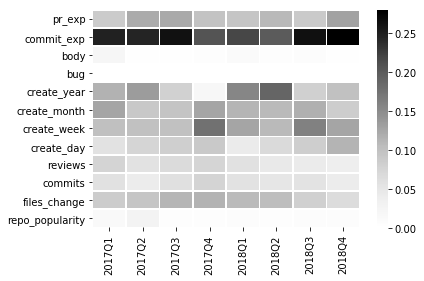

In [48]:
g = sns.heatmap(fi_df, linewidth = 0.5, cmap = 'Greys')

#### 6.5.4 Most important feature across 2017-2018
- based on each feature's importance rank in each quarter
- ORDER BY average rank over the 2 years
 

In [53]:
rf_output = [[important_feature_array[i].tolist()[j], 
              quarters[i],
              data_frame_columns[j]] 
             for i in range(len(quarters)) for j in range(len(data_frame_columns))]

cSchema = T.StructType([T.StructField("feature_importance", T.DoubleType())\
                      ,T.StructField("quarter", T.StringType())\
                      ,T.StructField("feature_name", T.StringType())])
fi_DF = spark.createDataFrame(rf_output,schema = cSchema)

fi_DF.createOrReplaceTempView('fi_DF')

spark.sql("""
SELECT feature_name, AVG(importance_RANK) as avg_rank
FROM
    (SELECT feature_name, quarter, DENSE_RANK() over (PARTITION BY quarter ORDER BY feature_importance DESC) as importance_rank
    FROM fi_DF
    ORDER BY quarter)
GROUP BY feature_name
ORDER BY avg_rank
""").show(12, False)

+---------------+--------+
|feature_name   |avg_rank|
+---------------+--------+
|commit_exp     |1.0     |
|create_week    |3.25    |
|pr_exp         |3.75    |
|create_month   |4.25    |
|create_year    |4.5     |
|files_change   |5.375   |
|create_day     |6.625   |
|reviews        |8.125   |
|commits        |8.125   |
|body           |10.5    |
|repo_popularity|10.5    |
|bug            |12.0    |
+---------------+--------+



# 7. Latency Prediction

In [121]:
latency_DF = spark.sql("""
SELECT

COUNT(1) over (PARTITION BY author_id ORDER BY closed_time ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING) AS pr_exp, 
COUNT(CASE WHEN merged = "true" THEN 1 END) over (PARTITION BY author_id ORDER BY closed_time ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING) AS commit_exp,
body,
YEAR(created_time) as create_year,
MONTH(created_time) as create_month,
WEEKOFYEAR(created_time) as create_week,
DAYOFYEAR(created_time) as create_day,
(comments + review_comments) as reviews,
commits,
files_change,
bug_fix(title) as fix,
COUNT(CASE WHEN merged = "true" THEN 1 END) over (PARTITION BY rp_id ORDER BY closed_time ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING) as repo_popularity, 
closed_time,
time_diff(created_time, merged_time) as acceptance_latency

FROM pr_DF
WHERE merged = "true"
""")

In [98]:
#latency_DF.write.mode('overwrite').parquet('latency_parquet')

In [2]:
#latency_DF = spark.read.parquet('latency_parquet')

### 7.1 Prepare data with ML pipeline

In [3]:
latency_DF = latency_DF.withColumn('bug', latency_DF.fix.cast('integer'))

In [4]:
categoricalColumns = []
numericCols = ['pr_exp', 'commit_exp', 'body','bug','create_year','create_month','create_week','create_day','reviews','commits','files_change','repo_popularity']

stages = []

    
label_stringIdx = StringIndexer(inputCol = 'acceptance_latency', outputCol = 'label')

stages += [label_stringIdx]


assemblerInputs = numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [5]:
latency_DF.printSchema()

root
 |-- pr_exp: long (nullable = true)
 |-- commit_exp: long (nullable = true)
 |-- body: long (nullable = true)
 |-- create_year: integer (nullable = true)
 |-- create_month: integer (nullable = true)
 |-- create_week: integer (nullable = true)
 |-- create_day: integer (nullable = true)
 |-- reviews: integer (nullable = true)
 |-- commits: integer (nullable = true)
 |-- files_change: long (nullable = true)
 |-- fix: boolean (nullable = true)
 |-- repo_popularity: long (nullable = true)
 |-- closed_time: timestamp (nullable = true)
 |-- acceptance_latency: string (nullable = true)
 |-- bug: integer (nullable = true)



In [6]:
stages

[StringIndexer_490fb42ed9d834412293, VectorAssembler_4db7a851d0976a5c1c6d]

In [7]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(latency_DF)
latency_DF_transformed = pipelineModel.transform(latency_DF)

selectedCols = ['label','features'] +['closed_time']
latency_DF_transformed = latency_DF_transformed.select(selectedCols)
latency_DF_transformed.printSchema()
latency_DF_transformed.createOrReplaceTempView('latency_DF')

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- closed_time: timestamp (nullable = true)



### 7.2 Split dataset every 3 month

In [8]:
latency_DF_transformed_Q1 = spark.sql("""
SELECT features, label FROM latency_DF
WHERE closed_time BETWEEN '2017-01-01' AND '2017-03-31'
""")

In [9]:
latency_DF_transformed_Q2 = spark.sql("""
SELECT features, label FROM latency_DF
WHERE closed_time BETWEEN '2017-04-01' AND '2017-06-30'
""")

In [10]:
latency_DF_transformed_Q3 = spark.sql("""
SELECT features, label FROM latency_DF
WHERE closed_time BETWEEN '2017-07-01' AND '2017-09-30'
""")

In [11]:
latency_DF_transformed_Q4 = spark.sql("""
SELECT features, label FROM latency_DF
WHERE closed_time BETWEEN '2017-10-01' AND '2017-12-31'
""")

In [12]:
latency_DF_transformed_Q5 = spark.sql("""
SELECT features, label FROM latency_DF
WHERE closed_time BETWEEN '2018-01-01' AND '2018-03-31'
""")

In [13]:
latency_DF_transformed_Q6 = spark.sql("""
SELECT features, label FROM latency_DF
WHERE closed_time BETWEEN '2018-04-01' AND '2018-06-30'
""")

In [14]:
latency_DF_transformed_Q7 = spark.sql("""
SELECT features, label FROM latency_DF
WHERE closed_time BETWEEN '2018-07-01' AND '2018-09-30'
""")

In [15]:
latency_DF_transformed_Q8 = spark.sql("""
SELECT features, label FROM latency_DF
WHERE closed_time > '2018-10-01'
""")

### 7.3 Split each quarter's dataset into train and test

In [16]:
latency_train1, latency_test1 = latency_DF_transformed_Q1.randomSplit([0.7, 0.3], seed = 1000)
latency_train2, latency_test2 = latency_DF_transformed_Q2.randomSplit([0.7, 0.3], seed = 1000)
latency_train3, latency_test3 = latency_DF_transformed_Q3.randomSplit([0.7, 0.3], seed = 1000)
latency_train4, latency_test4 = latency_DF_transformed_Q4.randomSplit([0.7, 0.3], seed = 1000)
latency_train5, latency_test5 = latency_DF_transformed_Q5.randomSplit([0.7, 0.3], seed = 1000)
latency_train6, latency_test6 = latency_DF_transformed_Q6.randomSplit([0.7, 0.3], seed = 1000)
latency_train7, latency_test7 = latency_DF_transformed_Q7.randomSplit([0.7, 0.3], seed = 1000)
latency_train8, latency_test8 = latency_DF_transformed_Q8.randomSplit([0.7, 0.3], seed = 1000)

### 7.4 Train random forest model with numTrees = 100

In [17]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', numTrees = 100, seed = 1000)

In [18]:
rf_model1_latency = rf.fit(latency_train1)
rf_model2_latency = rf.fit(latency_train2)
rf_model3_latency = rf.fit(latency_train3)
rf_model4_latency = rf.fit(latency_train4)
rf_model5_latency = rf.fit(latency_train5)
rf_model6_latency = rf.fit(latency_train6)
rf_model7_latency = rf.fit(latency_train7)
rf_model8_latency = rf.fit(latency_train8)

#### 7.4.1 Evaluate model with accuracy

In [19]:
evaluator = MulticlassClassificationEvaluator().setMetricName("accuracy")
evaluator_scores = [evaluator.evaluate(rf_model1_latency.transform(latency_test1)),
                    evaluator.evaluate(rf_model2_latency.transform(latency_test2)),
                    evaluator.evaluate(rf_model3_latency.transform(latency_test3)),
                    evaluator.evaluate(rf_model4_latency.transform(latency_test4)),
                    evaluator.evaluate(rf_model5_latency.transform(latency_test5)),
                    evaluator.evaluate(rf_model6_latency.transform(latency_test6)),
                    evaluator.evaluate(rf_model7_latency.transform(latency_test7)),
                    evaluator.evaluate(rf_model8_latency.transform(latency_test8))]
                    
spark.createDataFrame(evaluator_scores, T.FloatType()).describe().show()

+-------+--------------------+
|summary|               value|
+-------+--------------------+
|  count|                   8|
|   mean| 0.49299366399645805|
| stddev|0.007720494688798...|
|    min|           0.4832999|
|    max|          0.50407636|
+-------+--------------------+



In [48]:
import pandas as pd
quarters = ['2017Q1', 
            '2017Q2',
            '2017Q3',
            '2017Q4',
            '2018Q1',
            '2018Q2',
            '2018Q3',
            '2018Q4']
data_frame_columns = ['pr_exp', 'commit_exp', 'body','bug','create_year','create_month','create_week','create_day','reviews','commits','files_change','repo_popularity']

important_feature_array_latency = [rf_model1_latency.featureImportances.toArray(),
                          rf_model2_latency.featureImportances.toArray(),
                          rf_model3_latency.featureImportances.toArray(),
                          rf_model4_latency.featureImportances.toArray(),
                          rf_model5_latency.featureImportances.toArray(),
                          rf_model6_latency.featureImportances.toArray(),
                          rf_model7_latency.featureImportances.toArray(),
                          rf_model8_latency.featureImportances.toArray()]

latency_fi_df = pd.DataFrame(important_feature_array_latency, index = quarters, columns =  data_frame_columns ).T

#### 7.4.2 Feature Importance Heatmap

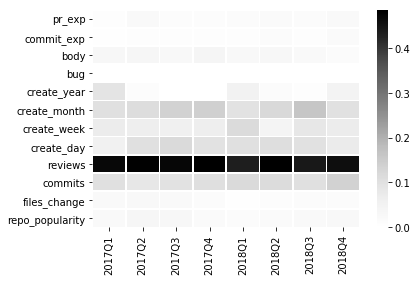

In [49]:
g = sns.heatmap(latency_fi_df, linewidth = 0.5, cmap = 'Greys')

#### 7.4.3 Average rank of feature importance

In [50]:
latency_rf_output = [[important_feature_array_latency[i].tolist()[j], 
              quarters[i],
              data_frame_columns[j]] 
             for i in range(len(quarters)) for j in range(len(data_frame_columns))]

cSchema = T.StructType([T.StructField("feature_importance", T.DoubleType())\
                      ,T.StructField("quarter", T.StringType())\
                      ,T.StructField("feature_name", T.StringType())])
latency_fi_DF = spark.createDataFrame(latency_rf_output,schema = cSchema)

latency_fi_DF.createOrReplaceTempView('latency_fi_DF')

spark.sql("""
SELECT feature_name, AVG(importance_RANK) as avg_rank
FROM
    (SELECT feature_name, quarter, DENSE_RANK() over (PARTITION BY quarter ORDER BY feature_importance DESC) as importance_rank
    FROM latency_fi_DF
    ORDER BY quarter)
GROUP BY feature_name
ORDER BY avg_rank
""").show(12, False)

+---------------+--------+
|feature_name   |avg_rank|
+---------------+--------+
|reviews        |1.0     |
|create_month   |2.5     |
|commits        |3.0     |
|create_day     |4.0     |
|create_week    |4.75    |
|body           |7.125   |
|repo_popularity|7.25    |
|pr_exp         |8.625   |
|create_year    |8.625   |
|files_change   |9.125   |
|commit_exp     |10.0    |
|bug            |12.0    |
+---------------+--------+



### 7.5 Hyperparameter Tuning and Crossvalidation

In [51]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', seed = 1000) 
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [10, 100, 200])
             .build())
evaluator = MulticlassClassificationEvaluator().setMetricName("accuracy")
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds= 10)

In [52]:
rf_model1_latency = cv.fit(latency_train1)
rf_model2_latency = cv.fit(latency_train2)
rf_model3_latency = cv.fit(latency_train3)
rf_model4_latency = cv.fit(latency_train4)
rf_model5_latency = cv.fit(latency_train5)
rf_model6_latency = cv.fit(latency_train6)
rf_model7_latency = cv.fit(latency_train7)
rf_model8_latency = cv.fit(latency_train8)

#### 7.5.1 Evaluate with accuracy
- The authors used accuracy in the paper

In [53]:
evaluator = MulticlassClassificationEvaluator().setMetricName("accuracy")

In [54]:
evaluator_scores = [evaluator.evaluate(rf_model1_latency.bestModel.transform(latency_test1)),
                    evaluator.evaluate(rf_model2_latency.bestModel.transform(latency_test2)),
                    evaluator.evaluate(rf_model3_latency.bestModel.transform(latency_test3)),
                    evaluator.evaluate(rf_model4_latency.bestModel.transform(latency_test4)),
                    evaluator.evaluate(rf_model5_latency.bestModel.transform(latency_test5)),
                    evaluator.evaluate(rf_model6_latency.bestModel.transform(latency_test6)),
                    evaluator.evaluate(rf_model7_latency.bestModel.transform(latency_test7)),
                    evaluator.evaluate(rf_model8_latency.bestModel.transform(latency_test8))]
                    
spark.createDataFrame(evaluator_scores, T.FloatType()).describe().show()

+-------+--------------------+
|summary|               value|
+-------+--------------------+
|  count|                   8|
|   mean|  0.4931233935058117|
| stddev|0.007700715137866...|
|    min|           0.4832999|
|    max|          0.50407636|
+-------+--------------------+



#### 7.5.2 Most important features in latency prediction
- according to https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.classification.RandomForestClassifier
- The important feature are determined by Gini importance
- In single tree, importance(feature j) = sum (over nodes which split on feature j) of the gain, where gain is scaled by the number of instances passing through node
- In random forest is each feature’s importance is the average of its importance across all trees in the ensemble
- Normalize the values to sum up to 1

In [55]:
import pandas as pd
quarters = ['2017Q1', 
            '2017Q2',
            '2017Q3',
            '2017Q4',
            '2018Q1',
            '2018Q2',
            '2018Q3',
            '2018Q4']
data_frame_columns = ['pr_exp', 'commit_exp', 'body','bug','create_year','create_month','create_week','create_day','reviews','commits','files_change','repo_popularity']

In [56]:
important_feature_array_latency = [rf_model1_latency.bestModel.featureImportances.toArray(),
                          rf_model2_latency.bestModel.featureImportances.toArray(),
                          rf_model3_latency.bestModel.featureImportances.toArray(),
                          rf_model4_latency.bestModel.featureImportances.toArray(),
                          rf_model5_latency.bestModel.featureImportances.toArray(),
                          rf_model6_latency.bestModel.featureImportances.toArray(),
                          rf_model7_latency.bestModel.featureImportances.toArray(),
                          rf_model8_latency.bestModel.featureImportances.toArray()]

latency_fi_df = pd.DataFrame(important_feature_array_latency, index = quarters, columns =  data_frame_columns ).T

#### 7.5.3 Latency Feature Importance heatmap 
- darker the color the more important feature it is 

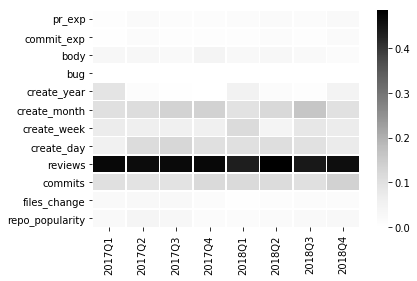

In [57]:
g = sns.heatmap(latency_fi_df, linewidth = 0.5, cmap = 'Greys')

#### 7.5.4 Most important feature for latency prediciton from 2017-2018
- smaller rank number the more important feature it is

In [58]:
latency_rf_output = [[important_feature_array_latency[i].tolist()[j], 
              quarters[i],
              data_frame_columns[j]] 
             for i in range(len(quarters)) for j in range(len(data_frame_columns))]

cSchema = T.StructType([T.StructField("feature_importance", T.DoubleType())\
                      ,T.StructField("quarter", T.StringType())\
                      ,T.StructField("feature_name", T.StringType())])
latency_fi_DF = spark.createDataFrame(latency_rf_output,schema = cSchema)

latency_fi_DF.createOrReplaceTempView('latency_fi_DF')

spark.sql("""
SELECT feature_name, AVG(importance_RANK) as avg_rank
FROM
    (SELECT feature_name, quarter, DENSE_RANK() over (PARTITION BY quarter ORDER BY feature_importance DESC) as importance_rank
    FROM latency_fi_DF
    ORDER BY quarter)
GROUP BY feature_name
ORDER BY avg_rank
""").show(12, False)

+---------------+--------+
|feature_name   |avg_rank|
+---------------+--------+
|reviews        |1.0     |
|create_month   |2.625   |
|commits        |3.0     |
|create_day     |3.875   |
|create_week    |4.75    |
|repo_popularity|7.25    |
|body           |7.25    |
|pr_exp         |8.625   |
|create_year    |8.75    |
|files_change   |9.0     |
|commit_exp     |9.875   |
|bug            |12.0    |
+---------------+--------+



### 7.6 Baseline Model
- Assume every pull request is classified into within_day
- Because within_day class has the most number in dataset

In [127]:
latency_DF.createOrReplaceTempView('baseline_DF')
spark.sql("""
SELECT day/total as baseline_model
FROM(
    SELECT COUNT(*) as total, COUNT(CASE WHEN acceptance_latency = "within_day" THEN 1 END) as day
    FROM baseline_DF
)
""").show()

+-------------------+
|     baseline_model|
+-------------------+
|0.42076397345251226|
+-------------------+

